In [75]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.optimize as op
plt.style.use("dark_background") # Config plots for dark mode, delete if on light mode
plt.rcParams['figure.dpi'] = 150 # Hi-res plots

In [76]:
station_data = pd.read_csv("../data/santander_locations.csv")
station_data.head() # Load the station data and inspect the first 5 rows
class StationIdError(IndexError):
    """Called when we try and read a non-existing station Id"""
    pass

def get_station_name(in_id):
    """Get station name from bike_data for a given id, catching any exceptions"""
    try:
        return station_data[station_data["Station.Id"] == in_id].StationName.iloc[0]
    except IndexError:
        StationIdError("No station matching input ID")

## Normalising time data

In [45]:
bike_data = pd.read_csv("../data/processed_df.csv", index_col=0)
bike_data.head() # Load the processed bike data and inspect the first 5 rows

# Find minimum start time
x = bike_data.min()["start_time"]
t_min = (x // 86400) * 86400

# Substract t_min from start_time and end_time
bike_data["start_time"] = (bike_data["start_time"] - t_min) / 60
bike_data["end_time"] = (bike_data["end_time"] - t_min) / 60

# Introduce random perturbations to make continuous
bike_data["start_time"] = bike_data["start_time"] + np.random.rand(*bike_data["start_time"].shape)
bike_data["end_time"] = bike_data["end_time"] + np.random.rand(*bike_data["end_time"].shape)

bike_data["duration"] = bike_data.end_time - bike_data.start_time

bike_data = bike_data.sort_values(by=["start_time"])

test_time = 12*7*24*60
test_bike_data = bike_data[bike_data.start_time <= test_time]

test_bike_data.head()

,start_id,end_id,start_time,duration,end_time,dist
1,103,37,2.578123,5.574368,8.152491,1.458333
2,39,539,2.578435,1.439637,4.018072,0.545517
3,785,785,2.986421,4.865156,7.851577,0.000000
5,708,573,3.124915,18.844363,21.969277,3.607290
4,341,159,3.468326,29.935354,33.403680,1.092775


In [46]:
test_sorted_stations = []
for st_id in test_bike_data.start_id.sort_values().unique():
    test_sorted_stations.append(test_bike_data[test_bike_data.start_id==st_id])

test_sorted_stations[0].head()

,start_id,end_id,start_time,duration,end_time,dist
1512,1,71,425.305838,8.688466,433.994304,1.718483
3498,1,3,498.695397,20.160099,518.855496,1.964612
5961,1,330,584.665329,28.206046,612.871375,4.997948
5977,1,433,585.823732,3.154602,588.978334,0.673108
6447,1,803,607.589603,15.040944,622.630547,2.768124


In [47]:
rates_dict = {}
for station in test_sorted_stations:
    time_elapsed = station.start_time.to_numpy()[-1] - station.start_time.to_numpy()[0]
    n_events = test_sorted_stations[0].size
    rate = n_events / time_elapsed

    rates_dict[station.start_id.unique()[0]]= rate

rates_dict


{1: 0.08485000070025103,
 2: 0.0845966399811968,
 3: 0.08497442324368037,
 4: 0.08496463266503287,
 5: 0.08487394982525313,
 6: 0.08493806390920831,
 7: 0.08465151072038672,
 8: 0.08455404156934793,
 9: 0.08491476073674172,
 10: 0.08484496983749668,
 11: 0.08449577849167755,
 12: 0.08500119100398196,
 13: 0.08464047940356753,
 14: 0.08475448201259105,
 15: 0.08493061180611976,
 16: 0.08478684815771682,
 17: 0.08462113122304044,
 18: 0.08464425850768233,
 19: 0.08488570120787517,
 20: 0.08490590988489721,
 22: 0.08464287486303003,
 23: 0.08483110036185991,
 24: 0.08454673123675553,
 25: 0.08456003209510224,
 26: 0.08481063278132146,
 27: 0.08487828423894482,
 28: 0.08473372685213386,
 29: 0.0845799431790508,
 30: 0.08476493747637111,
 31: 0.08466788390405491,
 32: 0.08478526810484603,
 33: 0.08452934523613984,
 34: 0.08477335381638736,
 36: 0.08483305920176436,
 37: 0.08470176687505909,
 38: 0.08475308884024817,
 39: 0.08449926675517072,
 40: 0.08482013827881152,
 41: 0.0848852521130382

In [48]:
rates = list(rates_dict.values())
cutoff = np.mean(rates) + 1.5*np.std(rates) # clearly nothing at minus 1.5sigma
max_rate = max(rates)
max_keys = [key for key, val in rates_dict.items() if val >= cutoff]
outliers = [get_station_name(i) for i in max_keys]
outliers

['Lansdowne Way Bus Garage, Stockwell',
 'George Row, Bermondsey',
 'Tower Wharf, Bermondsey']

In [71]:

p_values = {}

for station in test_sorted_stations:
    station_id = station.start_id.unique()[0]
    rate = rates_dict[station_id]
    inter_arrival_times = station.start_time.diff().to_numpy()[1:] # remove first as it is NaN
    station_p_values = np.exp(-1* rate * inter_arrival_times)
    p_values[station_id] = station_p_values

p_values[1]

array([1.97516355e-03, 6.79231284e-04, 9.06385591e-01, ...,
       2.24000709e-01, 1.88915487e-02, 7.96134613e-04])

0.9854864301306572


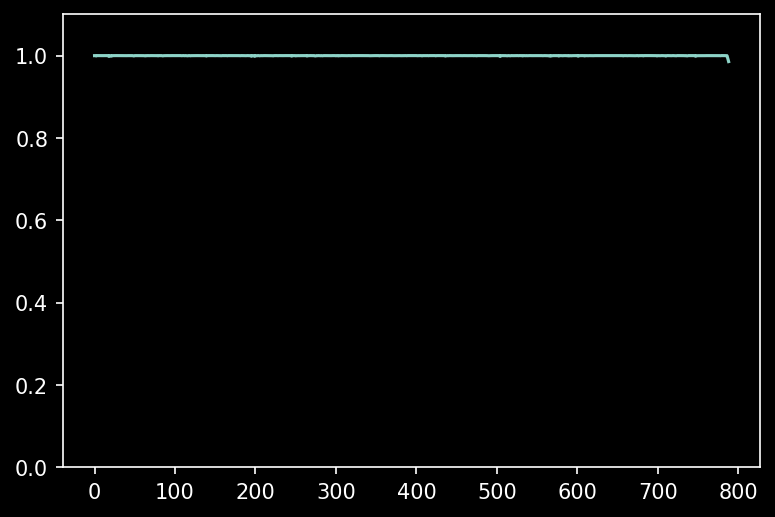

In [82]:
# Kolmogorov-smirnov:
kol_smir_test = {}
for station_id, pvals in p_values.items():
    kol_smir_test[station_id] = max(pvals) - min(pvals)

print(min(kol_smir_test.values()))

plt.plot(kol_smir_test.values())
plt.ylim([0,1.1])
plt.show()